### Plotting relative AAs and PTMs in PEAKS DN and PeaksDB results using python for _T. weissflogii_ rot experiment

Starting with:

    Peaks de novo results of PTM-optimized sequencing
    PeaksDB de novo-assisted results from PTM-optimized database searches

Goal:

    Figures comparing the modifcation type and extent in database and de novo peptides
    
Using:

    - pandas
    - matplotlib
    - numpy

In [1]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

### NAAF-corrected residue modification and AA composition across sample set

In [30]:
# for each of the 8 rot LCMS samples:
# read in NAAF totals that are combinations of PeaksDB and PeaksDN (see NAAF-combination nb)


sum_322 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-322.csv")
sum_323 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-323.csv")
sum_324 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-324.csv")
sum_325 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-325.csv")


frames = [sum_322, sum_323, sum_324, sum_325]
index = ['1. T0', '2. T2', '3. T5', '4. T12']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with sample names
names = ['T0', 'T2', 'T5', 'T12']
tot.insert(loc=0, column='sample', value=names)
tot.set_index('sample')

# separate out the dataframe into AAs and %PTMs, too
sum_AA = tot[['sample', 'A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'I-NAAF', 'K-NAAF', \
              'L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', \
              'W-NAAF', 'Y-NAAF']].copy()

sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Lys. w/ oxid.', 'Pro. w/ oxid.', \
               'Arg. w/ oxid.', 'Tyr. w/ oxid.', 'Asn. w/ deam.', 'Lys. w/ meth.', \
               'Arg. w/ meth.', 'Glu. w/ pyro.', 'Lys. w/ acet.']].copy()

# I think the 'overall modfied' is too biased by terminal residues to be meaningful
#sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', 'Gln. w/ deam.', 'Lys. w/ hydr.', \
               #'Arg. w/ meth.', 'Overall modified']].copy()

sum_ptm.head()

,sample,Cys. w/ carb.,Met. w/ oxid.,Lys. w/ oxid.,Pro. w/ oxid.,Arg. w/ oxid.,Tyr. w/ oxid.,Asn. w/ deam.,Lys. w/ meth.,Arg. w/ meth.,Glu. w/ pyro.,Lys. w/ acet.
0,T0,0.713782,0.336024,0.132060,0.138221,0.063120,0.244747,0.289083,0.115292,0.015490,0.007556,0.103685
1,T2,0.976172,0.635229,0.103688,0.179799,0.099164,0.137063,0.299277,0.077951,0.033178,0.170234,0.138694
2,T5,0.894950,0.352023,0.096419,0.140023,0.136939,0.312653,0.459223,0.042123,0.030540,0.029137,0.115444
3,T12,0.926475,0.562883,0.080798,0.150277,0.135308,0.213088,0.363498,0.218365,0.040676,0.058193,0.142754


In [32]:
# for each of the 4 undigested rot LCMS samples:
# read in NAAF totals that are combinations of PeaksDB and PeaksDN (see NAAF-combination nb)


sum_329 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-329.csv")
sum_330 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-330.csv")
sum_331 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-331.csv")
sum_332 = pd.read_csv("/home/millieginty/Documents/git-repos/rot-mayer/data/processed/NAAF-sums/NAAF-sum-332.csv")


frames = [sum_329, sum_330, sum_331, sum_332]
index = ['T0', 'T2', 'T5', 'T12']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with sample names
names = ['T0', 'T2', 'T5', 'T12']
tot.insert(loc=0, column='sample', value=names)
tot.set_index('sample')

# separate out the dataframe into AAs and %PTMs, too
sum_AA_undig = tot[['sample', 'A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'I-NAAF', 'K-NAAF', \
              'L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', \
              'W-NAAF', 'Y-NAAF']].copy()

sum_ptm_undig = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Lys. w/ oxid.', 'Pro. w/ oxid.', \
               'Arg. w/ oxid.', 'Tyr. w/ oxid.', 'Asn. w/ deam.', 'Lys. w/ meth.', \
               'Arg. w/ meth.', 'Glu. w/ pyro.', 'Lys. w/ acet.']].copy()

# I think the 'overall modfied' is too biased by terminal residues to be meaningful
#sum_ptm = tot[['sample', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', 'Gln. w/ deam.', 'Lys. w/ hydr.', \
               #'Arg. w/ meth.', 'Overall modified']].copy()

sum_ptm_undig.head()

,sample,Cys. w/ carb.,Met. w/ oxid.,Lys. w/ oxid.,Pro. w/ oxid.,Arg. w/ oxid.,Tyr. w/ oxid.,Asn. w/ deam.,Lys. w/ meth.,Arg. w/ meth.,Glu. w/ pyro.,Lys. w/ acet.
0,T0,1.000000,0.657314,0.055444,0.182496,0.094340,0.182119,0.590634,0.115869,0.077969,0.024595,0.051750
1,T2,1.000000,0.625796,0.091722,0.163558,0.067698,0.116725,0.277254,0.130772,0.115486,0.159053,0.102027
2,T5,0.980802,0.403256,0.037935,0.064225,0.068139,0.032015,0.805310,0.090380,0.222555,0.004478,0.100456
3,T12,1.000000,0.254886,0.115150,0.117475,0.098983,0.034366,0.732852,0.117631,0.164074,0.010892,0.123958


### 1. Peptide modifications:

<Figure size 720x360 with 0 Axes>

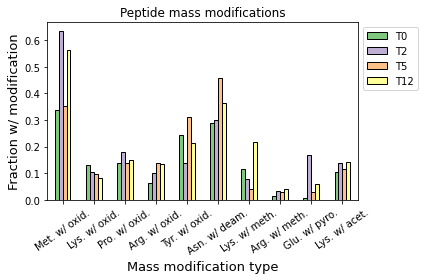

In [33]:
# plot mods across the dataset

sum_ptm_s = sum_ptm.drop(['sample'], axis=1)

ptm_sumT = sum_ptm_s.T

ptm_sumT.columns = ['T0', 'T2', 'T5', 'T12']

four_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598']
six_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
six_colors_q = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
seven_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']

fig = plt.figure(figsize = (10, 5)) 

ax = ptm_sumT.iloc[1:11].plot(kind="bar", title = 'Peptide mass modifications', \
                             color = seven_colors, edgecolor = 'black')

plt.xticks(rotation=35)

ax.set_ylabel('Fraction w/ modification', fontsize = 13)
ax.set_xlabel('Mass modification type', fontsize = 13)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#legend.get_frame().set_edgecolor('1.0')

plt.tight_layout()

plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/NAAF-digested-PTM-combined.png", dpi = 300)

#also save in latex manuscript dir
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/NAAF-ETNP-PTM-combined.png", dpi = 300)

<Figure size 720x360 with 0 Axes>

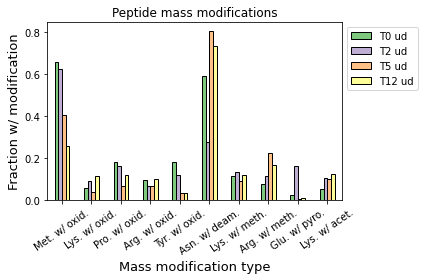

In [46]:
# plot mods across the dataset (undigested)

sum_ptm_undig_s = sum_ptm_undig.drop(['sample'], axis=1)

ptm_sumT_undig = sum_ptm_undig_s.T

ptm_sumT_undig.columns = ['T0 ud', 'T2 ud', 'T5 ud', 'T12 ud']

four_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598']
six_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
six_colors_q = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
seven_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']

fig = plt.figure(figsize = (10, 5)) 

ax = ptm_sumT_undig.iloc[1:11].plot(kind="bar", title = 'Peptide mass modifications', \
                             color = seven_colors, edgecolor = 'black')

plt.xticks(rotation=35)

ax.set_ylabel('Fraction w/ modification', fontsize = 13)
ax.set_xlabel('Mass modification type', fontsize = 13)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
#legend.get_frame().set_edgecolor('1.0')

plt.tight_layout()

plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/NAAF-undigested-PTM-combined.png", dpi = 300)

#also save in latex manuscript dir
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/NAAF-ETNP-PTM-combined.png", dpi = 300)

In [47]:
ptm_sumT.head(11)

,T0,T2,T5,T12
Cys. w/ carb.,0.713782,0.976172,0.894950,0.926475
Met. w/ oxid.,0.336024,0.635229,0.352023,0.562883
Lys. w/ oxid.,0.132060,0.103688,0.096419,0.080798
Pro. w/ oxid.,0.138221,0.179799,0.140023,0.150277
Arg. w/ oxid.,0.063120,0.099164,0.136939,0.135308
Tyr. w/ oxid.,0.244747,0.137063,0.312653,0.213088
Asn. w/ deam.,0.289083,0.299277,0.459223,0.363498
Lys. w/ meth.,0.115292,0.077951,0.042123,0.218365
Arg. w/ meth.,0.015490,0.033178,0.030540,0.040676
Glu. w/ pyro.,0.007556,0.170234,0.029137,0.058193


In [48]:
ptm_sumT_undig.head(11)

,T0 ud,T2 ud,T5 ud,T12 ud
Cys. w/ carb.,1.000000,1.000000,0.980802,1.000000
Met. w/ oxid.,0.657314,0.625796,0.403256,0.254886
Lys. w/ oxid.,0.055444,0.091722,0.037935,0.115150
Pro. w/ oxid.,0.182496,0.163558,0.064225,0.117475
Arg. w/ oxid.,0.094340,0.067698,0.068139,0.098983
Tyr. w/ oxid.,0.182119,0.116725,0.032015,0.034366
Asn. w/ deam.,0.590634,0.277254,0.805310,0.732852
Lys. w/ meth.,0.115869,0.130772,0.090380,0.117631
Arg. w/ meth.,0.077969,0.115486,0.222555,0.164074
Glu. w/ pyro.,0.024595,0.159053,0.004478,0.010892


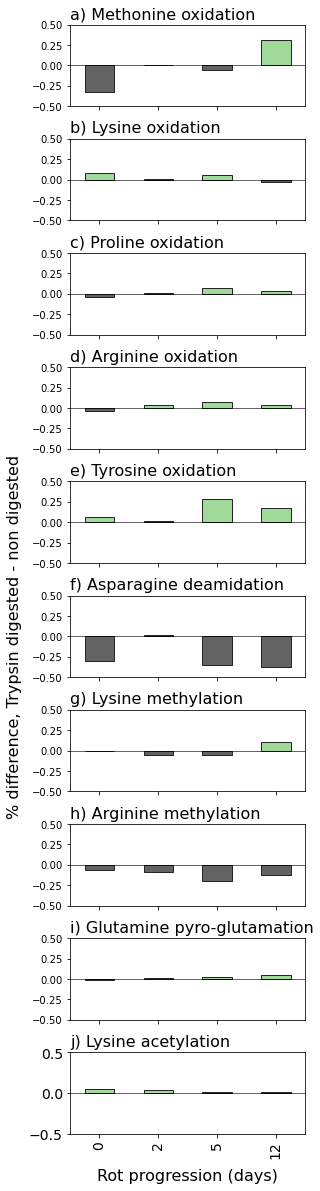

In [166]:
# add the two dataframes

diff = pd.concat([ptm_sumT, ptm_sumT_undig], axis=1)

diff['Day 0'] = diff['T0'] - diff['T0 ud']
diff['Day 2'] = diff['T2'] - diff['T2 ud']
diff['Day 5'] = diff['T5'] - diff['T5 ud']
diff['Day 12'] = diff['T12'] - diff['T12 ud']

# transpose and delete non diff columns

del diff['T0']
del diff['T2']
del diff['T5']
del diff['T12']

del diff['T0 ud']
del diff['T2 ud']
del diff['T5 ud']
del diff['T12 ud']

diff_plot = diff.T

# add column of Day #s
diff_plot['Day'] = [0, 2, 5, 12]

fig, axes = plt.subplots(figsize=(4, 16),nrows=10, ncols=1, sharex = True)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)

axes[0].text(0.50, 0.3, 'Enriched in non-digested',
        verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=12)


#  Methionine oxidation
diff_plot.plot(ax = axes[0], x="Day", y="Met. w/ oxid.", kind='bar', stacked=False, edgecolor = '#252525', \
              color=(diff_plot['Met. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[0].set_title('a) Methonine oxidation', fontsize = 16, loc='left')
axes[0].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[0].get_legend().remove()
axes[0].set_ylim([-0.5, 0.5])


# Lysine oxidation
diff_plot.plot(ax = axes[1], x="Day", y="Lys. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Lys. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[1].set_title('b) Lysine oxidation', fontsize = 16, loc='left')
axes[1].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[1].get_legend().remove()
axes[1].set_ylim([-0.5, 0.5])

# Proline oxidation
diff_plot.plot(ax = axes[2], x="Day", y="Pro. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Pro. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[2].set_title('c) Proline oxidation', fontsize = 16, loc='left')
axes[2].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[2].get_legend().remove()
axes[2].set_ylim([-0.5, 0.5])

# Arginine oxidation
diff_plot.plot(ax = axes[3], x="Day", y="Arg. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Arg. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[3].set_title('d) Arginine oxidation', fontsize = 16, loc='left')
axes[3].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[3].get_legend().remove()
axes[3].set_ylim([-0.5, 0.5])

# Tyrosine oxidation
diff_plot.plot(ax = axes[4], x="Day", y="Tyr. w/ oxid.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Tyr. w/ oxid.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[4].set_title('e) Tyrosine oxidation', fontsize = 16, loc='left')
axes[4].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[4].get_legend().remove()
axes[4].set_ylim([-0.5, 0.5])

# Asparagine deamidation
diff_plot.plot(ax = axes[5], x="Day", y="Asn. w/ deam.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Asn. w/ deam.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[5].set_title('f) Asparagine deamidation', fontsize = 16, loc='left')
axes[5].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[5].get_legend().remove()
axes[5].set_ylabel("% difference, Trypsin digested - non digested", fontsize = 16, labelpad = 10)
axes[5].set_ylim([-0.5, 0.5])

# Lysine methylation
diff_plot.plot(ax = axes[6], x="Day", y="Lys. w/ meth.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Lys. w/ meth.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[6].set_title('g) Lysine methylation', fontsize = 16, loc='left')
axes[6].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[6].get_legend().remove()
axes[6].set_ylim([-0.5, 0.5])

# Arginine methylation
diff_plot.plot(ax = axes[7], x="Day", y="Arg. w/ meth.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Arg. w/ meth.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[7].set_title('h) Arginine methylation', fontsize = 16, loc='left')
axes[7].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[7].get_legend().remove()
axes[7].set_ylim([-0.5, 0.5])

# Glutamine pyro-gluatmation
diff_plot.plot(ax = axes[8], x="Day", y="Glu. w/ pyro.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Glu. w/ pyro.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[8].set_title('i) Glutamine pyro-glutamation', fontsize = 16, loc='left')
axes[8].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[8].get_legend().remove()
axes[8].set_ylim([-0.5, 0.5])

# Lysine acetylation
diff_plot.plot(ax = axes[9], x="Day", y="Lys. w/ acet.", kind='bar', stacked=False,  edgecolor = '#252525', \
              color=(diff_plot['Lys. w/ acet.'] > 0).map({True: '#a1d99b',
                                                    False: '#636363'}))
axes[9].set_title('j) Lysine acetylation', fontsize = 16, loc='left')
axes[9].axhline(0,color='black', linewidth = 0.6) # x = 0
axes[9].get_legend().remove()
axes[9].set_ylim([-0.5, 0.5])
axes[9].set_xlabel("Rot progression (days)", fontsize = 16, labelpad = 10)
axes[9].tick_params(labelsize= 14)

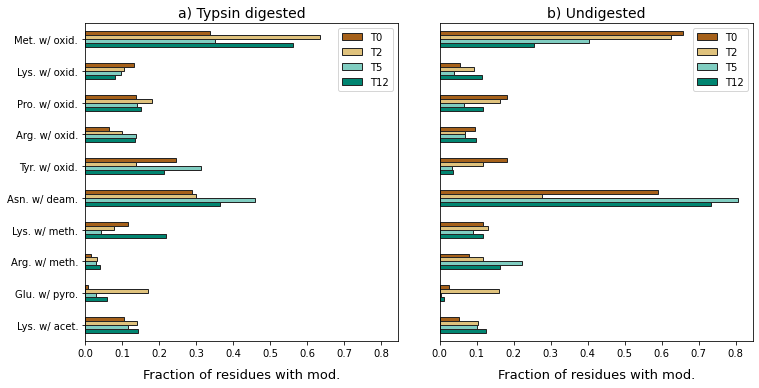

In [27]:
# df just digested
sus = ptm_sumT[['T0', 'T2', 'T5', 'T12']].copy()
sus = sus.drop('Cys. w/ carb.', axis=0)
# df just undig
sink = ptm_sumT_undig[['T0', 'T2', 'T5', 'T12']].copy()
sink = sink.drop('Cys. w/ carb.', axis=0)

colors_3 = ['#99d594', '#ffffbf', '#fc8d59']
colors_4 = ['#a6611a', '#dfc27d', '#80cdc1', '#018571']

fig, axes = plt.subplots(figsize=(10, 5),nrows=1, ncols=2, sharex = True)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

sus.plot(ax=axes[0], kind='barh', stacked=False, color = colors_4, edgecolor = '#252525')
sink.plot(ax=axes[1], kind='barh', stacked=False, color = colors_4, edgecolor = '#252525')

axes[0].set_title('a) Typsin digested', fontsize = 14)
axes[0].invert_yaxis()
axes[0].set_xlabel("Fraction of residues with mod.", fontsize = 13,  labelpad = 10)

axes[1].set_title('b) Undigested', fontsize = 14)
axes[1].set_ylabel("")
axes[1].yaxis.set_ticks([])
axes[1].invert_yaxis()
axes[1].set_xlabel("Fraction of residues with mod.", fontsize = 13, labelpad = 10)


# save figure in ptm-analyses dir
plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-ptm.png", dpi = 300, bbox_inches='tight', transparent=True)

# also save in manuscript latex dir high res
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/ETNP-PTMs-sep.png", dpi = 300, bbox_inches='tight')

In [28]:
#combine the dataframes

frames = [ptm_sumT, ptm_sumT_undig]
  
ptm_combine = pd.concat(frames)

ptm_combine.head()

,T0,T2,T5,T12
Cys. w/ carb.,0.713782,0.976172,0.894950,0.926475
Met. w/ oxid.,0.336024,0.635229,0.352023,0.562883
Lys. w/ oxid.,0.132060,0.103688,0.096419,0.080798
Pro. w/ oxid.,0.138221,0.179799,0.140023,0.150277
Arg. w/ oxid.,0.063120,0.099164,0.136939,0.135308


### NAAF-corrected residue modification and AA composition across sample set
### 2. AA composition:

In [7]:
sum_AA.head()

,sample,A-NAAF,C-NAAF,D-NAAF,E-NAAF,F-NAAF,G-NAAF,H-NAAF,I-NAAF,K-NAAF,...,M-NAAF,N-NAAF,P-NAAF,Q-NAAF,R-NAAF,S-NAAF,T-NAAF,V-NAAF,W-NAAF,Y-NAAF
0,1. T0 dig.,4340.423046,311.083912,2009.170186,3196.675259,1420.698938,3489.163300,473.968822,539.0,2696.301930,...,1213.822365,3898.976475,4840.163591,1034.314030,4795.231174,5212.363199,3971.563961,4843.548564,384.457565,924.264423
1,2. T2 dig.,3901.218088,734.208470,2567.271117,5371.900556,1294.088984,3279.846385,523.078359,645.0,4489.593151,...,977.031025,2917.980115,5506.069620,1555.703533,4343.180418,3931.823384,4487.858384,7179.808836,529.589975,1003.189058
2,3. T5 dig.,3067.657714,245.676576,2076.479266,3396.731355,1805.013124,3674.757071,329.540057,377.0,2650.592500,...,1184.999138,3650.321698,3447.072612,917.870811,3480.261318,1342.969017,2466.745529,2493.875996,355.431984,1400.772901
3,4. T12 dig.,3892.988447,224.761328,3485.922204,4084.357848,2568.155267,4241.527648,286.423803,217.0,3446.020033,...,1853.035469,3821.789507,3650.751328,1156.540669,5034.934239,1968.424036,3747.387163,4267.520555,669.599524,964.649362


In [17]:
# sum all the AAs in each dataset, making a new column

sum_AA['AA-Total-NAAF'] = sum_AA['A-NAAF'] + sum_AA['C-NAAF'] + sum_AA['D-NAAF'] + sum_AA['E-NAAF'] \
+ sum_AA['F-NAAF'] + sum_AA['G-NAAF'] + sum_AA['H-NAAF'] + sum_AA['K-NAAF'] + sum_AA['I-NAAF'] + sum_AA['L-NAAF'] \
+ sum_AA['M-NAAF'] + sum_AA['N-NAAF'] + sum_AA['P-NAAF'] + sum_AA['Q-NAAF'] + sum_AA['R-NAAF'] \
+ sum_AA['S-NAAF'] + sum_AA['T-NAAF'] + sum_AA['V-NAAF'] + sum_AA['W-NAAF'] + sum_AA['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

sum_AA['A_RelNAAF'] = sum_AA['A-NAAF']/sum_AA['AA-Total-NAAF']  #A
sum_AA['C_RelNAAF'] = sum_AA['C-NAAF']/sum_AA['AA-Total-NAAF']  #C
sum_AA['D_RelNAAF'] = sum_AA['D-NAAF']/sum_AA['AA-Total-NAAF']  #D
sum_AA['E_RelNAAF'] = sum_AA['E-NAAF']/sum_AA['AA-Total-NAAF']  #E
sum_AA['F_RelNAAF'] = sum_AA['F-NAAF']/sum_AA['AA-Total-NAAF']  #F
sum_AA['G_RelNAAF'] = sum_AA['G-NAAF']/sum_AA['AA-Total-NAAF']  #G
sum_AA['H_RelNAAF'] = sum_AA['H-NAAF']/sum_AA['AA-Total-NAAF']  #H
sum_AA['K_RelNAAF'] = sum_AA['K-NAAF']/sum_AA['AA-Total-NAAF']  #K
sum_AA['I/L_RelNAAF'] = (sum_AA['I-NAAF'] + sum_AA['L-NAAF'])/sum_AA['AA-Total-NAAF']  #I/L
sum_AA['M_RelNAAF'] = sum_AA['M-NAAF']/sum_AA['AA-Total-NAAF']  #M
sum_AA['N_RelNAAF'] = sum_AA['N-NAAF']/sum_AA['AA-Total-NAAF']  #N
sum_AA['P_RelNAAF'] = sum_AA['P-NAAF']/sum_AA['AA-Total-NAAF']  #P
sum_AA['Q_RelNAAF'] = sum_AA['Q-NAAF']/sum_AA['AA-Total-NAAF']  #Q
sum_AA['R_RelNAAF'] = sum_AA['R-NAAF']/sum_AA['AA-Total-NAAF']  #R
sum_AA['S_RelNAAF'] = sum_AA['S-NAAF']/sum_AA['AA-Total-NAAF']  #S
sum_AA['T_RelNAAF'] = sum_AA['T-NAAF']/sum_AA['AA-Total-NAAF']  #T
sum_AA['V_RelNAAF'] = sum_AA['V-NAAF']/sum_AA['AA-Total-NAAF']  #V
sum_AA['W_RelNAAF'] = sum_AA['W-NAAF']/sum_AA['AA-Total-NAAF']  #W
sum_AA['Y_RelNAAF'] = sum_AA['Y-NAAF']/sum_AA['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
sum_relAA = sum_AA[['sample', 'A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

#export as a csv

sum_relAA.to_csv("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-RelNAAF-AAs.csv")

sum_relAA.head(6)

,sample,A_RelNAAF,C_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,N_RelNAAF,P_RelNAAF,Q_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,W_RelNAAF,Y_RelNAAF
0,1. T0 dig.,0.074637,0.005349,0.034549,0.054970,0.024430,0.059999,0.008150,0.046365,0.156437,0.020873,0.067046,0.083231,0.017786,0.082458,0.089631,0.068294,0.083289,0.006611,0.015894
1,2. T2 dig.,0.062620,0.011785,0.041208,0.086226,0.020772,0.052646,0.008396,0.072064,0.123702,0.015683,0.046838,0.088380,0.024971,0.069714,0.063111,0.072036,0.115246,0.008501,0.016103
2,3. T5 dig.,0.068839,0.005513,0.046597,0.076223,0.040505,0.082462,0.007395,0.059480,0.147570,0.026592,0.081914,0.077353,0.020597,0.078098,0.030136,0.055354,0.055963,0.007976,0.031434
3,4. T12 dig.,0.068094,0.003931,0.060974,0.071442,0.044921,0.074191,0.005010,0.060276,0.136536,0.032412,0.066849,0.063857,0.020230,0.088069,0.034431,0.065547,0.074645,0.011712,0.016873


In [8]:
# sum all the AAs in each dataset EXCEPT those not included in THAA analyses, making a new column
# THAA doesn't get C, N, Q, and W

sum_AA['AA-Total-NAAF-THAAinc'] = sum_AA['A-NAAF'] + + sum_AA['D-NAAF'] + sum_AA['E-NAAF'] \
+ sum_AA['F-NAAF'] + sum_AA['G-NAAF'] + sum_AA['H-NAAF'] + sum_AA['K-NAAF'] + sum_AA['I-NAAF'] + sum_AA['L-NAAF'] \
+ sum_AA['M-NAAF'] + sum_AA['P-NAAF'] + sum_AA['R-NAAF'] \
+ sum_AA['S-NAAF'] + sum_AA['T-NAAF'] + sum_AA['V-NAAF'] + sum_AA['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

sum_AA['A_RelNAAF'] = sum_AA['A-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #A
#sum_AA['C_RelNAAF'] = sum_AA['C-NAAF']/sum_AA['AA-Total-NAAF']  #C
sum_AA['D_RelNAAF'] = sum_AA['D-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #D
sum_AA['E_RelNAAF'] = sum_AA['E-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #E
sum_AA['F_RelNAAF'] = sum_AA['F-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #F
sum_AA['G_RelNAAF'] = sum_AA['G-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #G
sum_AA['H_RelNAAF'] = sum_AA['H-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #H
sum_AA['K_RelNAAF'] = sum_AA['K-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #K
sum_AA['I/L_RelNAAF'] = (sum_AA['I-NAAF'] + sum_AA['L-NAAF'])/sum_AA['AA-Total-NAAF-THAAinc']  #I/L
sum_AA['M_RelNAAF'] = sum_AA['M-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #M
#sum_AA['N_RelNAAF'] = sum_AA['N-NAAF']/sum_AA['AA-Total-NAAF']  #N
sum_AA['P_RelNAAF'] = sum_AA['P-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #P
#sum_AA['Q_RelNAAF'] = sum_AA['Q-NAAF']/sum_AA['AA-Total-NAAF']  #Q
sum_AA['R_RelNAAF'] = sum_AA['R-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #R
sum_AA['S_RelNAAF'] = sum_AA['S-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #S
sum_AA['T_RelNAAF'] = sum_AA['T-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #T
sum_AA['V_RelNAAF'] = sum_AA['V-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #V
#sum_AA['W_RelNAAF'] = sum_AA['W-NAAF']/sum_AA['AA-Total-NAAF']  #W
sum_AA['Y_RelNAAF'] = sum_AA['Y-NAAF']/sum_AA['AA-Total-NAAF-THAAinc']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions (THAA compatible)
DigPep_relAA_THAAcompatible = sum_AA[['sample', 'A_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I/L_RelNAAF', 'M_RelNAAF', 'P_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'Y_RelNAAF']].copy()

#export as a csv

DigPep_relAA_THAAcompatible.to_csv("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-RelNAAF-AAs-THAAcompatible.csv")

DigPep_relAA_THAAcompatible.head(6)

,sample,A_RelNAAF,D_RelNAAF,E_RelNAAF,F_RelNAAF,G_RelNAAF,H_RelNAAF,K_RelNAAF,I/L_RelNAAF,M_RelNAAF,P_RelNAAF,R_RelNAAF,S_RelNAAF,T_RelNAAF,V_RelNAAF,Y_RelNAAF
0,1. T0 dig.,0.082636,0.038252,0.060860,0.027048,0.066429,0.009024,0.051334,0.173202,0.023110,0.092150,0.091295,0.099236,0.075613,0.092215,0.017597
1,2. T2 dig.,0.068972,0.045388,0.094973,0.022879,0.057986,0.009248,0.079374,0.136249,0.017273,0.097345,0.076785,0.069513,0.079343,0.126936,0.017736
2,3. T5 dig.,0.077872,0.052711,0.086225,0.045820,0.093283,0.008365,0.067285,0.166935,0.030081,0.087503,0.088346,0.034091,0.062618,0.063307,0.035558
3,4. T12 dig.,0.075890,0.067954,0.079620,0.050064,0.082684,0.005584,0.067177,0.152167,0.036123,0.071168,0.098151,0.038372,0.073051,0.083191,0.018805


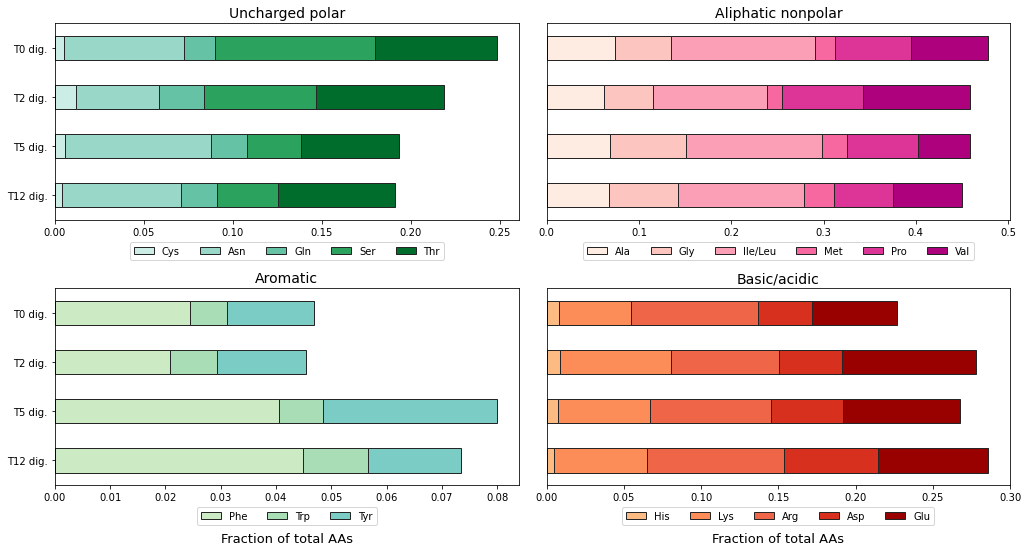

In [23]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

sum_relAA_des = sum_relAA.sort_values('sample',ascending=False)

col_up = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
col_na = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
col_ar = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
col_ba = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# divide up the dataframe into 4 smaller dataframes based on AA class

# uncharged polar: cysteine, asparagine, glutamine, serine, threonine
up = sum_relAA_des[['sample', 'C_RelNAAF', 'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', 'T_RelNAAF']].copy()
up_names = ['sample', 'Cys', 'Asn', 'Gln', 'Ser', 'Thr']
up.columns = up_names

# nonpolar, aliphatic R-group: alanine, glycine, methionine, proline, valine
na = sum_relAA_des[['sample', 'A_RelNAAF', 'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF',\
                    'P_RelNAAF', 'V_RelNAAF']].copy()
na_names = ['sample', 'Ala', 'Gly', 'Ile/Leu', 'Met', 'Pro', 'Val']
na.columns = na_names

# aromatic R-group: phenylalanine, tryptophan, tyrosine
ar = sum_relAA_des[['sample', 'F_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy() 
ar_names = ['sample', 'Phe', 'Trp', 'Tyr']
ar.columns = ar_names

# basic and acidic R-group: hisdiine, lysine, arginine, aspartic acid, glutamic acid
ba = sum_relAA_des[['sample', 'H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 'D_RelNAAF', 'E_RelNAAF']].copy()
ba_names = ['sample', 'His', 'Lys', 'Arg', 'Asp', 'Glu']
ba.columns = ba_names

# plot AA comps

fig, axes = plt.subplots(figsize=(14, 7),nrows=2, ncols=2)
plt.tight_layout()

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace= 0.06, hspace= 0.35)

up.plot(ax=axes[0,0], x='sample', kind='barh', stacked=True, color = col_up, edgecolor = '#252525')
na.plot(ax=axes[0,1], x='sample', kind='barh', stacked=True, color = col_na, edgecolor = '#252525')
ar.plot(ax=axes[1,0], x='sample', kind='barh', stacked=True, color = col_ar, edgecolor = '#252525')
ba.plot(ax=axes[1,1], x='sample', kind='barh', stacked=True, color = col_ba, edgecolor = '#252525')

axes[0,0].set_title('Uncharged polar', fontsize = 14)
axes[0,0].set_ylabel("")
axes[0,0].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=5)
axes[0,0].set_yticklabels( ('T12 dig.', 'T5 dig.', 'T2 dig.', 'T0 dig.') )

axes[0,1].set_title('Aliphatic nonpolar', fontsize = 14)
axes[0,1].yaxis.set_ticks([])
axes[0,1].set_ylabel("")
axes[0,1].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=6)

axes[1,0].set_title('Aromatic', fontsize = 14)
axes[1,0].set_xlabel('Fraction of total AAs', labelpad = 30, fontsize = 13)
axes[1,0].set_ylabel("")
axes[1,0].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=3)
axes[1,0].set_yticklabels( ('T12 dig.', 'T5 dig.', 'T2 dig.', 'T0 dig.') )

axes[1,1].set_title('Basic/acidic', fontsize = 14)
axes[1,1].yaxis.set_ticks([])
axes[1,1].set_xlabel('Fraction of total AAs', labelpad = 30, fontsize = 13)
axes[1,1].set_ylabel("")
axes[1,1].legend(bbox_to_anchor=(0.5, -0.09), loc='upper center', ncol=5)

#fig.suptitle('Relative amino acid composition of ETNP POM peptides', y = 1.07, size = 15)

# save figure in ptm-analyses dir
plt.savefig("/home/millieginty/Documents/git-repos/rot-mayer/analyses/AA-composition/digested-AA-NAAFs.png", dpi = 300, bbox_inches='tight', transparent=True)

# also save in manuscript latex dir high res
#plt.savefig("/home/millieginty/Documents/git-repos/denovo-etnp/ETNP-AAs.png", dpi = 300, bbox_inches='tight')

In [ ]:
na.head()

### NAAF-corrected residue modification and AA composition in individual samples
### Comet, PeaksDB, and Peaks *de novo* separated:

### 3. Peptide modifcations:

In [ ]:
# read in NAAF totals csvs made in SKQ-Peaks (de novo), SKQ-PeaksDB, and SKQ-Comet notebooks
# bringing in Comet > XCorr 2.17 (will say 3) and de novo peptides >80% ALC
# also reading in Peaks DB peptides >20 -10lgP (all we imported)

# 231 100 m suspended

peaks80_231 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PeaksDN-PTMopt/231/ETNP-SKQ17-231-100m-0.3-JA2_PTMopt_15ppm_DN80_NAAF_totals.csv")
comet_231 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/TPP-PTMopt/ETNP-SKQ17-TPP-PTM-opt_15ppm_FUNGI/231/ETNP-SKQ17-231-100m-0.3-JA2_PTMopt_Comet15_1FDR_NAAF_totals.csv")
peaksdb_231 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/ETNP-SKQ17/PeaksDB-PTMopt/231/ETNP_SKQ17_PEAKSDB20_231-100m-0.3-JA2_15ppm_NAAF_totals")

frames = [peaks80_231, comet_231, peaksdb_231]
index = ['peaks80_231', 'comet_231', 'peaksdb_231']

# concatenate dataframes
tot_231 = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot_231 = tot_231.loc[:, ~tot_231.columns.str.contains('^Unnamed')]

# reindex with peaks and comet
names = ['peaks80_231', 'comet_231', 'peaksdb_231']
tot_231.insert(loc=0, column='data source', value=names)
tot_231.set_index('data source')

# separate out the dataframe into AAs and %PTMs, too
AA_231 = tot_231[['data source', 'A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'I-NAAF', 'K-NAAF', \
              'L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', \
              'W-NAAF', 'Y-NAAF']].copy()

ptm_231 = tot_231[['data source', '% C w/ carb. NAAF', '% M w/ oxid. NAAF', '% N w/ deam. NAAF', \
               '% Q w/ deam. NAAF', '% K w/ hydr. NAAF', '% R w/ meth. NAAF']].copy()

# made a column in ptm that's the total modified fraction of residues that could be variably modified
ptm_231['Total modified'] = (ptm_231['% C w/ carb. NAAF'] + ptm_231['% M w/ oxid. NAAF'] + ptm_231['% N w/ deam. NAAF'] + \
                            ptm_231['% Q w/ deam. NAAF'] + ptm_231['% K w/ hydr. NAAF'] + ptm_231['% R w/ meth. NAAF']) / 5

# rename columns because they're not actually percentages
ptm_231.columns = ['data source', 'Cys. w/ carb.', 'Met. w/ oxid.', 'Asn. w/ deam.', \
                   'Gln. w/ deam.', 'Lys. w/ hydr.', 'Arg. w/ meth.', 'Total modified']


tot_231.head()

In [ ]:
# plot mods

ptmds = ptm_231.drop(['data source'], axis=1)

ptmT = ptmds.T

ptmT.columns = ['231 De novo > 80% ALC', '231 Comet < 0.1% FDR', '231 Peaks DB > 20 -10lgP']

six_colors = ['#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd']
six_colors_q = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f']
seven_colors = ['#7fc97f', '#beaed4', '#fdc086', '#ffff99', '#386cb0', '#f0027f', '#bf5b17']

ax = ptmT.iloc[1:7].plot(kind="barh", title = 'Peptide mass modifications in 100 m suspended', color = seven_colors, edgecolor = 'black')
plt.xticks(rotation=35)
#ax.get_legend().remove()

ax.set_xlabel('fraction with modification')
ax.set_ylabel('mass modification type')
legend = plt.legend()
legend.get_frame().set_edgecolor('1.0')

plt.tight_layout()

#plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/MED4_Abs_PTM")

# also save in latex manuscript dir
#plt.savefig("/home/millieginty/Documents/med-manuscripts/de-novo-etnp/rewrite-may2020/AGU/MED-AGU/MED4_Abs_PTM", dpi = 300)

## OLD: approach-separated NAAF corrected and absolute PTMs/AAs
### Excludes PeaksDB

### For Comet peptides:

In [ ]:
# get AA composition for each sample

totalcomet231_NAAF = 
totalcomet233_NAAF = 
totalcomet243_NAAF = 
totalcomet378_NAAF = 
totalcomet278_NAAF = 
totalcomet273_NAAF = 

frames = [totalcomet231_NAAF, totalcomet233_NAAF, totalcomet243_NAAF, totalcomet378_NAAF, \
         totalcomet278_NAAF, totalcomet273_NAAF]
index = ['totalcomet231_NAAF', 'totalcomet233_NAAF', 'totalcomet243_NAAF', 'totalcomet378_NAAF', \
         'totalcomet278_NAAF', 'totalcomet273_NAAF']

# concatenate dataframes
NAAFtotcomet = pd.concat(frames, sort=False, ignore_index=True)

# reindex 
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
NAAFtotcomet.insert(loc=0, column='data source', value=names)
NAAFtotcomet.set_index('data source')

# sum all the AAs in each dataset, making a new column
NAAFtotcomet['AA-Total-NAAF'] = NAAFtotcomet['A-NAAF'] + NAAFtotcomet['C-NAAF'] + NAAFtotcomet['D-NAAF'] + NAAFtotcomet['E-NAAF'] \
+ NAAFtotcomet['F-NAAF'] + NAAFtotcomet['G-NAAF'] + NAAFtotcomet['H-NAAF'] + NAAFtotcomet['K-NAAF'] + NAAFtotcomet['I-NAAF'] + NAAFtotcomet['L-NAAF'] \
+ NAAFtotcomet['M-NAAF'] + NAAFtotcomet['N-NAAF'] + NAAFtotcomet['P-NAAF'] + NAAFtotcomet['Q-NAAF'] + NAAFtotcomet['R-NAAF'] \
+ NAAFtotcomet['S-NAAF'] + NAAFtotcomet['T-NAAF'] + NAAFtotcomet['V-NAAF'] + NAAFtotcomet['W-NAAF'] + NAAFtotcomet['Y-NAAF'] \

# calculate the relative (NAAF-normalized) AA composition (fractions of AA total for each dataset)

NAAFtotcomet['A_RelNAAF'] = NAAFtotcomet['A-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #A
NAAFtotcomet['C_RelNAAF'] = NAAFtotcomet['C-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #C
NAAFtotcomet['D_RelNAAF'] = NAAFtotcomet['D-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #D
NAAFtotcomet['E_RelNAAF'] = NAAFtotcomet['E-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #E
NAAFtotcomet['F_RelNAAF'] = NAAFtotcomet['F-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #F
NAAFtotcomet['G_RelNAAF'] = NAAFtotcomet['G-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #G
NAAFtotcomet['H_RelNAAF'] = NAAFtotcomet['H-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #H
NAAFtotcomet['K_RelNAAF'] = NAAFtotcomet['K-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #K
NAAFtotcomet['I_RelNAAF'] = NAAFtotcomet['I-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #I
NAAFtotcomet['L_RelNAAF'] = NAAFtotcomet['L-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #I
NAAFtotcomet['M_RelNAAF'] = NAAFtotcomet['M-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #M
NAAFtotcomet['N_RelNAAF'] = NAAFtotcomet['N-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #N
NAAFtotcomet['P_RelNAAF'] = NAAFtotcomet['P-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #P
NAAFtotcomet['Q_RelNAAF'] = NAAFtotcomet['Q-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #Q
NAAFtotcomet['R_RelNAAF'] = NAAFtotcomet['R-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #R
NAAFtotcomet['S_RelNAAF'] = NAAFtotcomet['S-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #S
NAAFtotcomet['T_RelNAAF'] = NAAFtotcomet['T-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #T
NAAFtotcomet['V_RelNAAF'] = NAAFtotcomet['V-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #V
NAAFtotcomet['W_RelNAAF'] = NAAFtotcomet['W-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #W
NAAFtotcomet['Y_RelNAAF'] = NAAFtotcomet['Y-NAAF']/NAAFtotcomet['AA-Total-NAAF']  #Y

# make a smaller dataframe with just the relative, NAAF-normalized AA compositions
comet_AA_RelNAAF = NAAFtotcomet[['A_RelNAAF', 'C_RelNAAF', 'D_RelNAAF', 'E_RelNAAF', 'F_RelNAAF', 'G_RelNAAF', 'H_RelNAAF', \
                      'K_RelNAAF', 'I_RelNAAF', 'L_RelNAAF', 'M_RelNAAF', 'N_RelNAAF', 'P_RelNAAF', 'Q_RelNAAF', 'R_RelNAAF', \
                      'S_RelNAAF', 'T_RelNAAF', 'V_RelNAAF', 'W_RelNAAF', 'Y_RelNAAF']].copy()

# make a smaller dataframe with just the % of PTMs on affected residues
comet_PTM_NAAF = NAAFtotcomet[['% C w/ carb. NAAF', '% M w/ oxid. NAAF', \
                        '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                        '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF']].copy()

# reindex with samples names
names = ['1. 100 m sus.', '2. 265 m sus.', '3. 965 m sus.', '4. 100 m trap', '6. 265 m trap', '6. 965 m trap']
comet_AA_RelNAAF.insert(loc=0, column='data source', value=names)
comet_AA_RelNAAF.set_index('data source')
comet_PTM_NAAF.insert(loc=0, column='data source', value=names)
comet_PTM_NAAF.set_index('data source')

# write the big dataframe to a csv in the PTM analyses dir
#NAAFtotcomet.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/ETNP-SKQ17-NAAFtotals-DN50.csv")

comet_PTM_NAAF.head(6)

## Visualizing the results:

### First, PEAKS AA and PTM NAAF-corrected results:

In [ ]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

#plt.subplots(nrows=2, ncols=2)
#plt.subplots(figsize=(20,10)) 
#plt.tight_layout()

AA_RelNAAF50_sorted_desc= AA_RelNAAF50.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar
ax1 = AA_RelNAAF50_sorted_desc.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors1, edgecolor = '#252525')
ax1.legend_.remove()
ax1.set_xlabel('Relative AA fraction', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('a) Uncharged polar', fontsize = 16)


# nonpolar, aliphatic R-group
ax2 = AA_RelNAAF50_sorted_desc.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True, color = my_colors2, edgecolor = '#252525')
ax2.legend_.remove()
ax2.set_xlabel('Relative AA fraction', fontsize = 12)
ax2.set_ylabel('')
ax2.set_title('b) Nonpolar aliphatic R', fontsize = 16)

# aromatic R-group
ax3 = AA_RelNAAF50_sorted_desc.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors3, edgecolor = '#252525')
ax3.legend_.remove()
ax3.set_xlabel('Relative AA fraction', fontsize = 12)
ax3.set_ylabel('')
ax3.set_title('c) Aromatic R-group', fontsize = 16)


# Basic and acidic R-group
ax4 = AA_RelNAAF50_sorted_desc.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            'D_RelNAAF', 'E_RelNAAF', 
                            ], x='data source', stacked=True, color = my_colors4, edgecolor = '#252525')
ax4.legend_.remove()
ax4.set_xlabel('Relative AA fraction', fontsize = 12)
ax4.set_ylabel('')
ax4.set_title('d) Basic and acidic R-groups', fontsize = 16)


In [ ]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

#plt.subplots(nrows=2, ncols=2)
#plt.subplots(figsize=(20,10)) 
#plt.tight_layout()

AA_RelNAAF80_sorted_desc= AA_RelNAAF80.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar
ax1 = AA_RelNAAF80_sorted_desc.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors1, edgecolor = '#252525')
ax1.legend_.remove()
ax1.set_xlabel('Relative AA fraction', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('a) Uncharged polar', fontsize = 16)


# nonpolar, aliphatic R-group
ax2 = AA_RelNAAF80_sorted_desc.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I/L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True, color = my_colors2, edgecolor = '#252525')
ax2.legend_.remove()
ax2.set_xlabel('Relative AA fraction', fontsize = 12)
ax2.set_ylabel('')
ax2.set_title('b) Nonpolar aliphatic R', fontsize = 16)

# aromatic R-group
ax3 = AA_RelNAAF80_sorted_desc.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors3, edgecolor = '#252525')
ax3.legend_.remove()
ax3.set_xlabel('Relative AA fraction', fontsize = 12)
ax3.set_ylabel('')
ax3.set_title('c) Aromatic R-group', fontsize = 16)


# Basic and acidic R-group
ax4 = AA_RelNAAF80_sorted_desc.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            'D_RelNAAF', 'E_RelNAAF', 
                            ], x='data source', stacked=True, color = my_colors4, edgecolor = '#252525')
ax4.legend_.remove()
ax4.set_xlabel('Relative AA fraction', fontsize = 12)
ax4.set_ylabel('')
ax4.set_title('d) Basic and acidic R-groups', fontsize = 16)


In [ ]:
# plot NAAF-corrected AA compositions in a heatmap

AA_RelNAAF50.style.background_gradient(cmap ='viridis')

In [ ]:
# plot NAAF-corrected AA compositions in a heatmap

AA_RelNAAF80.style.background_gradient(cmap ='viridis')

### Same process for NAAF-corrected PTM occurance

In [ ]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

PTM_NAAF50_sorted_desc= PTM_NAAF50.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_c = '#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax = PTM_NAAF50_sorted_desc.plot.barh(y=['% M w/ oxid. NAAF', \
                                           '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                                           '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF'
                            ], x='data source', stacked=True, color = divergent_c, edgecolor = '#252525')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('% of residues with modifications', fontsize = 12)
ax.set_ylabel('')
ax.set_title('NAAF corrected modifications', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/percent-skq17-ptms-DN50", transparent=True)

In [ ]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

PTM_NAAF80_sorted_desc= PTM_NAAF80.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_c = '#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax = PTM_NAAF80_sorted_desc.plot.barh(y=['% M w/ oxid. NAAF', \
                                           '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                                           '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF'
                            ], x='data source', stacked=True, color = divergent_c, edgecolor = '#252525')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('% of residues with modifications', fontsize = 12)
ax.set_ylabel('')
ax.set_title('NAAF corrected modifications', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/percent-skq17-ptms-DN80", transparent=True)

### Absolute PTM occurance

In [ ]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

NAAFtot50_sorted_desc= NAAFtot50.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_6 = '#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221'


# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax1 = NAAFtot50_sorted_desc.plot.barh(y=['M-oxid-NAAF', 'N-deam-NAAF', \
                                            'Q-deam-NAAF', 'K-hydr-NAAF', \
                                            'P-hydr-NAAF', 'R-meth-NAAF'
                            ], x='data source', stacked=True, color = divergent_6, edgecolor = '#252525')

ax1.legend()
ax1.set_xlabel('# of residues with modification', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('NAAF corrected modification occurance', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/absolute-skq17-ptms-DN50", figsize=(15,10), transparent=True)

In [ ]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

NAAFtot80_sorted_desc= NAAFtot80.sort_values('data source', ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_6 = '#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221'


# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar

ax1 = NAAFtot80_sorted_desc.plot.barh(y=['M-oxid-NAAF', 'N-deam-NAAF', \
                                            'Q-deam-NAAF', 'K-hydr-NAAF', \
                                            'P-hydr-NAAF', 'R-meth-NAAF'
                            ], x='data source', stacked=True, color = divergent_6, edgecolor = '#252525')

ax1.legend()
ax1.set_xlabel('# of residues with modification', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('NAAF corrected modification occurance', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/absolute-skq17-ptms-DN80", figsize=(15,10), transparent=True)

## Now for Comet AA and PTM NAAF-corrected results:

In [ ]:
# plotting the NAAF-corrected AA compositions by residue type (charge, side group)
# order the horizontal bars by sample

#plt.subplots(nrows=2, ncols=2)
#plt.subplots(figsize=(20,10)) 
#plt.tight_layout()

comet_AA_RelNAAF_sorted_desc= comet_AA_RelNAAF.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e', '#7a0177'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


# uncharged polar
ax1 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['C_RelNAAF', \
                             'N_RelNAAF', 'Q_RelNAAF', 'S_RelNAAF', \
                             'T_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors1, edgecolor = '#252525')
ax1.legend_.remove()
ax1.set_xlabel('Relative AA fraction', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('a) Uncharged polar', fontsize = 16)


# nonpolar, aliphatic R-group
ax2 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['A_RelNAAF', \
                             'G_RelNAAF','I_RelNAAF', 'L_RelNAAF', 'M_RelNAAF', \
                             'P_RelNAAF', \
                             'V_RelNAAF',\
                            ], x='data source', stacked=True, color = my_colors2, edgecolor = '#252525')
ax2.legend_.remove()
ax2.set_xlabel('Relative AA fraction', fontsize = 12)
ax2.set_ylabel('')
ax2.set_title('b) Nonpolar aliphatic R', fontsize = 16)

# aromatic R-group
ax3 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['F_RelNAAF', \
                              'W_RelNAAF', 'Y_RelNAAF' \
                            ], x='data source', stacked=True, color = my_colors3, edgecolor = '#252525')
ax3.legend_.remove()
ax3.set_xlabel('Relative AA fraction', fontsize = 12)
ax3.set_ylabel('')
ax3.set_title('c) Aromatic R-group', fontsize = 16)


# Basic and acidic R-group
ax4 = comet_AA_RelNAAF_sorted_desc.plot.barh(y=['H_RelNAAF', 'K_RelNAAF', 'R_RelNAAF', 
                            'D_RelNAAF', 'E_RelNAAF', 
                            ], x='data source', stacked=True, color = my_colors4, edgecolor = '#252525')
ax4.legend_.remove()
ax4.set_xlabel('Relative AA fraction', fontsize = 12)
ax4.set_ylabel('')
ax4.set_title('d) Basic and acidic R-groups', fontsize = 16)


### Same process for Comet NAAF-corrected PTM occurance

In [ ]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

comet_PTM_NAAF_sorted_desc= comet_PTM_NAAF.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_c = '#d53e4f', '#fc8d59', '#fee08b', '#e6f598', '#99d594', '#3288bd'

# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax = comet_PTM_NAAF_sorted_desc.plot.barh(y=['% M w/ oxid. NAAF', \
                                           '% N w/ deam. NAAF', '% Q w/ deam. NAAF', \
                                           '% K w/ hydr. NAAF', '% P w/ hydr. NAAF', '% R w/ meth. NAAF'
                            ], x='data source', stacked=True, color = divergent_c, edgecolor = '#252525')

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel('% of residues with modifications', fontsize = 12)
ax.set_ylabel('')
ax.set_title('NAAF corrected modifications', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/percent-skq17-ptms-comet3", transparent=True)

### Absolute PTM occurance for Comet results

In [ ]:
# plotting the ABSOLUTE NAAF-corrected PTMs
# order the horizontal bars by sample

comet_PTM_NAAF_sorted_desc= comet_PTM_NAAF.sort_values('data source',ascending=False)


my_colors1 = '#ccece6', '#99d8c9', '#66c2a4', '#2ca25f', '#006d2c'
my_colors2 = '#feebe2', '#fcc5c0', '#fa9fb5', '#f768a1', '#dd3497', '#ae017e'
my_colors3 = '#ccebc5', '#a8ddb5', '#7bccc4', '#4eb3d3', '#2b8cbe', '#08589e'
my_colors4 = '#fdbb84', '#fc8d59', '#ef6548', '#d7301f', '#990000'
divergent_6 = '#c51b7d', '#e9a3c9', '#fde0ef', '#e6f5d0', '#a1d76a', '#4d9221'


# another color option: 
#purples = '#bfd3e6', '#9ebcda', '#8c96c6', '#8c6bb1', '#88419d', '#6e016b'


ax1 = comet_PTM_NAAF_sorted_desc.plot.barh(y=['M-oxid-NAAF', 'N-deam-NAAF', \
                                            'Q-deam-NAAF', 'K-hydr-NAAF', \
                                            'P-hydr-NAAF', 'R-meth-NAAF'
                            ], x='data source', stacked=True, color = divergent_6, edgecolor = '#252525')

ax1.legend()
ax1.set_xlabel('# of residues with modification', fontsize = 12)
ax1.set_ylabel('')
ax1.set_title('NAAF corrected modification occurance', fontsize = 16)

plt.savefig("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pronovo-2020-ptm/absolute-skq17-ptms-comet3", figsize=(15,10), transparent=True)